In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [71]:
import pandas as pd
train = pd.read_csv('/content/drive/My Drive/train.csv')


In [3]:
train.describe()

,label
count,4421.000000
mean,485.515042
std,288.534563
min,0.000000
25%,233.000000
50%,466.000000
75%,736.000000
max,1012.000000


In [72]:
train=train[:100]

In [73]:
train

,id,label
0,0001_00002550000001.jpg,0
1,0001_00002550000005.jpg,0
2,0001_00002550001_0000255_script.jpg,0
3,0001_00002620000011.jpg,1
4,0001_00002620001_0000262_script.jpg,1
...,...,...
95,0002_00003080000009.jpg,21
96,0002_00003080000010.jpg,21
97,0002_00003080000011.jpg,21
98,0002_00003080002_0000308_script.jpg,21


In [44]:
# importing the libraries
import pandas as pd
import numpy as np

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

In [45]:
from skimage.transform import rescale, resize, downscale_local_mean

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
 23%|██▎       | 23/100 [00:00<00:01, 69.98it/s]

not a TIFF file (header b'' not valid)


100%|██████████| 100/100 [00:02<00:00, 45.75it/s]


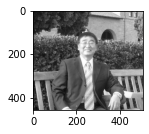

In [46]:
train_img = []
for img_name in tqdm(train['id']):
  try:
    # defining the image path
    image_path = '/content/drive/My Drive/datasetImages/' + img_name
    # reading the image
    img = imread(image_path, as_gray=True)
 
    # normalizing the pixel values
    img /= 255.0
    # converting the type of pixel to float 32
    img = img.astype('float32')
    plt.subplot(221), plt.imshow(img, cmap='gray')
    #print(img.shape)
    img=resize(img, (28, 28),
                       anti_aliasing=False)
    #print(img.shape)
    # appending the image into the list
    train_img.append(img)
  except Exception as e:
    print(e)
    pass

In [47]:
# converting the list to numpy array
train_x = np.array(train_img)
# defining the target
#for train['id'] in lst
train_y = train['label'].values


In [48]:
train_x.shape

(99, 28, 28)

In [49]:
train_y=train_y[:-1]

In [50]:
train_y.shape


(99,)

(<matplotlib.axes._subplots.AxesSubplot at 0x7fcc98a92090>,
 <matplotlib.image.AxesImage at 0x7fcc97e35910>)

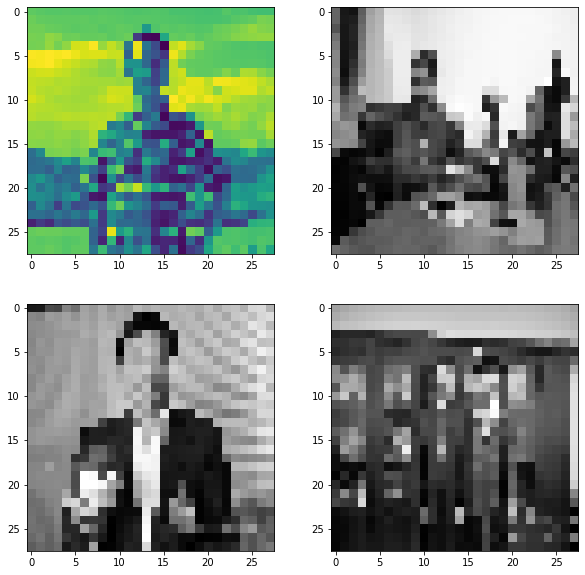

In [52]:
i = 0
plt.figure(figsize=(10,10))
plt.subplot(221), plt.imshow(train_x[i])
plt.subplot(222), plt.imshow(train_x[i+25], cmap='gray')
plt.subplot(223), plt.imshow(train_x[i+50], cmap='gray')
plt.subplot(224), plt.imshow(train_x[i+75], cmap='gray')

In [53]:

train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = 0.1)
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape)

(((89, 28, 28), (89,)), ((10, 28, 28), (10,)))

In [54]:
train_x = train_x.reshape(89, 1, 28, 28)
train_x  = torch.from_numpy(train_x)

# converting the target into torch format
train_y = train_y.astype(int);
train_y = torch.from_numpy(train_y)

# shape of training data
train_x.shape, train_y.shape

(torch.Size([89, 1, 28, 28]), torch.Size([89]))

In [56]:
# converting training images into torch format
val_x = val_x.reshape(10, 1, 28, 28)
val_x  = torch.from_numpy(val_x)

# converting the target into torch format
val_y = val_y.astype(int);
val_y = torch.from_numpy(val_y)

# shape of validation data
val_x.shape, val_y.shape

(torch.Size([10, 1, 28, 28]), torch.Size([10]))

In [57]:
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = Sequential(
            Linear(4 * 7 * 7, 23)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [58]:
# defining the model
model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.07)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=196, out_features=23, bias=True)
  )
)


In [59]:
def train(epoch):
    model.train()
    tr_loss = 0
    # getting the training set
    x_train, y_train = Variable(train_x), Variable(train_y)
    # getting the validation set
    x_val, y_val = Variable(val_x), Variable(val_y)
    # converting the data into GPU format
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        x_val = x_val.cuda()
        y_val = y_val.cuda()

    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    output_train = model(x_train)
    output_val = model(x_val)

    # computing the training and validation loss
    loss_train = criterion(output_train, y_train)
    loss_val = criterion(output_val, y_val)
    train_losses.append(loss_train)
    val_losses.append(loss_val)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    if epoch%2 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)

In [60]:
# defining the number of epochs
n_epochs = 25
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# training the model
for epoch in range(n_epochs):
    train(epoch)
    torch.save(model,"/content/drive/My Drive/model{}".format(epoch))

Epoch :  1 	 loss : tensor(3.6284, grad_fn=<NllLossBackward>)
Epoch :  3 	 loss : tensor(12.1952, grad_fn=<NllLossBackward>)
Epoch :  5 	 loss : tensor(10.2302, grad_fn=<NllLossBackward>)
Epoch :  7 	 loss : tensor(7.4578, grad_fn=<NllLossBackward>)
Epoch :  9 	 loss : tensor(6.3185, grad_fn=<NllLossBackward>)
Epoch :  11 	 loss : tensor(5.6898, grad_fn=<NllLossBackward>)
Epoch :  13 	 loss : tensor(5.2186, grad_fn=<NllLossBackward>)
Epoch :  15 	 loss : tensor(5.7140, grad_fn=<NllLossBackward>)
Epoch :  17 	 loss : tensor(6.8359, grad_fn=<NllLossBackward>)
Epoch :  19 	 loss : tensor(7.9816, grad_fn=<NllLossBackward>)
Epoch :  21 	 loss : tensor(9.1952, grad_fn=<NllLossBackward>)
Epoch :  23 	 loss : tensor(10.5346, grad_fn=<NllLossBackward>)
Epoch :  25 	 loss : tensor(12.1647, grad_fn=<NllLossBackward>)


In [61]:
model=torch.load("/content/drive/My Drive/model24")

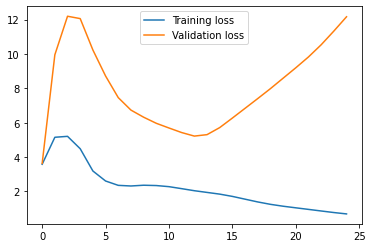

In [62]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

In [63]:
def check(img):
  test_img = []
  l=[img]
  for img_name in tqdm(l):
    try:
      # defining the image path
      image_path = '/content/drive/My Drive/datasetImages/' + img_name
      # reading the image
      img = imread(image_path, as_gray=True)

      # normalizing the pixel values
      img /= 255.0
      # converting the type of pixel to float 32
      img = img.astype('float32')
      plt.subplot(221), plt.imshow(img, cmap='gray')
      #print(img.shape)
      img=resize(img, (28, 28),anti_aliasing=False)
      #print(img.shape)
      # appending the image into the list
      test_img.append(img)
    except Exception as e:
      print(e)
      pass
      # appending the image into the list
  test_x = np.array(test_img)
  test_x = test_x.reshape(1, 1, 28, 28)
  test_x  = torch.from_numpy(test_x)    
  with torch.no_grad():
    output = model(test_x)

  softmax = torch.exp(output).cpu()
  prob = list(softmax.numpy())
  predictions = np.argmax(prob, axis=1)
  return predictions


100%|██████████| 1/1 [00:00<00:00, 24.11it/s]


array([1])

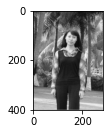

In [75]:
check("0001_00002620000011.jpg")